In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from derivative import dxdt
from scipy.integrate import solve_ivp

In [3]:
class SINDY:
    def __init__(self,U,T,u0,T_traj=0,fit_time=False,derivation="total",POLYNOMIAL_ORDER = 2,USE_TRIG = False,THRESHOLD = 0.025,MAX_ITERATIONS = 10):
        self.u=U
        self.t=T
        self.u0=u0
        self.polynomial_order=POLYNOMIAL_ORDER
        self.use_trig=USE_TRIG
        self.threshold=THRESHOLD
        self.max_iterations=MAX_ITERATIONS
        self.derivation=derivation
        self.uprime_1=self.calculate_total_variation_derivatives()
        self.uprime_2=self.calculate_finite_difference_derivatives()
        self.theta=self.create_library(u=self.u)
        self.xi=self.calculate_regression()
        self.T_traj=T_traj
        self.fit_time=fit_time
        

        

    def create_library(self,u) -> np.ndarray:
        
        """Creates a matrix containing a library of candidate functions.
        For example, if our u depends on x, y, and z, and we specify
        polynomial_order=2 and use_trig=false, our terms would be:
        1, x, y, z, x^2, xy, xz, y^2, yz, z^2."""


        (m,n) = u.shape
        theta = np.ones((m, 1))

        # Polynomials of order 1.
        theta = np.hstack((theta, u))

        # Polynomials of order 2.
        if self.polynomial_order >= 2:
            for i in range(n):
                for j in range(i, n):
                    theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

        # Polynomials of order 3.
        if self.polynomial_order >= 3:
            for i in range(n):
                for j in range(i, n):
                    for k in range(j, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

        # Polynomials of order 4.
        if self.polynomial_order >= 4:
            for i in range(n):
                for j in range(i, n):
                    for k in range(j, n):
                        for l in range(k, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1]))

        # Polynomials of order 5.
        if self.polynomial_order >= 5:
            for i in range(n):
                for j in range(i, n):
                    for k in range(j, n):
                        for l in range(k, n):
                            for m in range(l, n):
                                theta = np.hstack(
                                    (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                    u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

        if self.use_trig:
            for i in range(1, 11):
                theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

        return (theta)

    def calculate_finite_difference_derivatives(self):
        """Calculates the derivatives of u using finite differences.

        Finite difference derivatives are quick and simple to calculate. They
        may not do as well as total variation derivatives at denoising
        derivatives in general, but in our simple non-noisy scenario, they
        do just as well.
        """
        uprime = dxdt(self.u.T, self.t, kind="finite_difference", k=1).T
        row,col=self.u.shape
        uprime=uprime.reshape(row,col)
        
        return (uprime)


    def calculate_total_variation_derivatives(self):
        """Calculates the derivatives of u using the "total variation
        derivatives with regularization" technique.

        The paper recommends using the "total variation
        derivatives with regularization" technique, because it's effective
        at denoising the derivatives. This technique has been implemented in the
        "derivative" package, so we'll use this API.

        This takes several minutes to run.
        """
        uprime = dxdt(self.u.T, self.t, kind="trend_filtered", order=0, alpha=1e-2)
        
        row,col=self.u.shape
        uprime=uprime.reshape(row,col)
        return uprime
    
    def calculate_regression(self) -> np.ndarray:
        """Finds a xi matrix that fits theta * xi = uprime, using the sequential
        thresholded least-squares algorithm, which is a regression algorithm that
        promotes sparsity.

        The authors of the SINDy paper designed this algorithm as an alternative
        to LASSO, because they found LASSO to be algorithmically unstable, and
        computationally expensive for very large data sets.
        """
        if self.derivation=="finite":
            uprime=self.uprime_2
            uprime=uprime.astype('float64')
        elif self.derivation=="total":
            uprime=self.uprime_1
            
        
        # Solve theta * xi = uprime in the least-squares sense.
        xi = np.linalg.lstsq(self.theta, uprime, rcond=None)[0]
        n = xi.shape[1]
        

        # Add sparsity.
        for _ in range(self.max_iterations):
            small_indices = np.abs(xi) < self.threshold
            xi[small_indices] = 0
            for j in range(n):
                big_indices = np.logical_not(small_indices[:, j])
                xi[big_indices, j] = np.linalg.lstsq(self.theta[:, big_indices],
                                                    uprime[:, j],
                                                    rcond=None)[0]

        return xi
    def approximation(self,_: float, u: np.ndarray) -> np.ndarray:
        """For a given 1 x 3 u vector, this function calculates the corresponding
        1 x n row of the theta matrix, and multiples that theta row by the n x 3 xi.
        The result is the corresponding 1 x 3 du/dt vector.
        """
        _,col=self.u.shape
        
        create_library=self.create_library
        theta = create_library(u=u.reshape((1, col)))
        
        return theta @ self.xi


    def compute_trajectory(self) -> np.ndarray:
        """Calculates the trajectory of the model discovered by SINDy.

        Given an initial value for u, we call the lorenz_approximation function
        to calculate the corresponding du/dt. Then, using a numerical method,
        solve_ivp uses that derivative to calculate the next value of u, using the
        xi matrix discovered by SINDy. This process repeats, until we have all
        values of the u trajectory.
        """
        #t0 = 0.001
        #dt = 0.001
        #tmax = 100
        #n = int(tmax / dt + 1)

        #t = np.linspace(start=t0, stop=tmax, num=n)
        if self.fit_time==False:
            time=self.t.flatten()
        else:
            time=self.T_traj.flatten()
            
        t0 = time[0]
        tmax = time[-1]
        #dt = 1
        #n = int(tmax / dt + 1)
        #t = np.linspace(start=t0, stop=tmax, num=n)
       
        result = solve_ivp(fun=self.approximation,
                        t_span=(t0, tmax),
                        y0=self.u0,
                        t_eval=time)#,
                        #args=(self.xi))#, self.polynomial_order, self.use_trig))
        u = result.y.T
        status=result.status
        print(status)
        return u
        



In [4]:
def plot_org_sim(org,sim,legend):
    plt.figure(figsize=(12, 7))
    for i in range(org.shape[1]):
        plt.plot(org[:,i],label=legend[i]+"Initial Data")
        plt.plot(sim[:,i],label=legend[i]+"Simulation")
    plt.legend()

In [5]:
def Plotting_covid(x,y,approximation=False,u_approximation=0):
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, marker='.', color='blue')
    if approximation==True:
        plt.plot(x, u_approximation, marker='.', color='red')
    plt.title('Increase of Infection Over First 50 Days for Diamond Princess')
    plt.xlabel('Day (Since First Case)')
    plt.ylabel('Number of Confirmed Cases')
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [6]:
def CalcAccuracy(Actual_Y, Predicted_y):
    
    actual_values=Actual_Y
    predicted_values=np.array(Predicted_y)
    error= abs(actual_values-predicted_values)
    mse=np.mean(np.square(error))
    rel_err=mse/np.mean(np.square(actual_values))
    accuracy=1-rel_err
    return(accuracy)

In [7]:
# Load the file using pandas
corona_data = pd.read_csv('corona_data.dat', sep="\t", engine='python')  # Assuming tab-separated data
# Filter the data for "Diamond Princess"
diamond_princess_data = corona_data[corona_data['LOCATION'] == 'Diamond Princess']



In [8]:
diamond_princess_data

,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,CONFIRMED,DEATHS,RECOVERED
11260,Diamond Princess,2020-02-07 23:59:00,0,61,0,0
11261,Diamond Princess,2020-02-08 23:59:00,1,61,0,0
11262,Diamond Princess,2020-02-09 23:59:00,2,64,0,0
11263,Diamond Princess,2020-02-10 23:59:00,3,135,0,0
11264,Diamond Princess,2020-02-11 23:59:00,4,135,0,0
...,...,...,...,...,...,...
11517,Diamond Princess,2020-10-21 23:59:00,257,712,13,659
11518,Diamond Princess,2020-10-22 23:59:00,258,712,13,659
11519,Diamond Princess,2020-10-23 23:59:00,259,712,13,659
11520,Diamond Princess,2020-10-24 23:59:00,260,712,13,659


In [9]:
#create day column
diamond_princess_data['Day'] = range(1, len(diamond_princess_data) + 1)
# Filter the Diamond Princess data for the first 50 days
diamond_princess_first_50_days = diamond_princess_data[diamond_princess_data['Day'] <= 50]

C:\Users\fisay\AppData\Local\Temp\ipykernel_21220\475064246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diamond_princess_data['Day'] = range(1, len(diamond_princess_data) + 1)


In [10]:
U=diamond_princess_first_50_days['CONFIRMED'].to_numpy()
U=U.reshape(50,1)
T=diamond_princess_first_50_days['Day'].to_numpy()
T=T.reshape(50,1)
u0=U[0]

## E

#### Pa

In [11]:

testings=SINDY(U,T,u0,derivation="total",POLYNOMIAL_ORDER = 1,USE_TRIG = False,THRESHOLD = 0.025,MAX_ITERATIONS = 10)
u_approximation=testings.compute_trajectory()

0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+03, tolerance: 1.683e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\fisay\AppData\Roaming\Python\Python39\site-packages\derivative\differentiation.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dX = np.array([list(self.compute_for(t, x, np.arange(len(t)))) for x in X])


In [12]:
testings.xi

array([[50.22021377],
       [-0.06252625]])

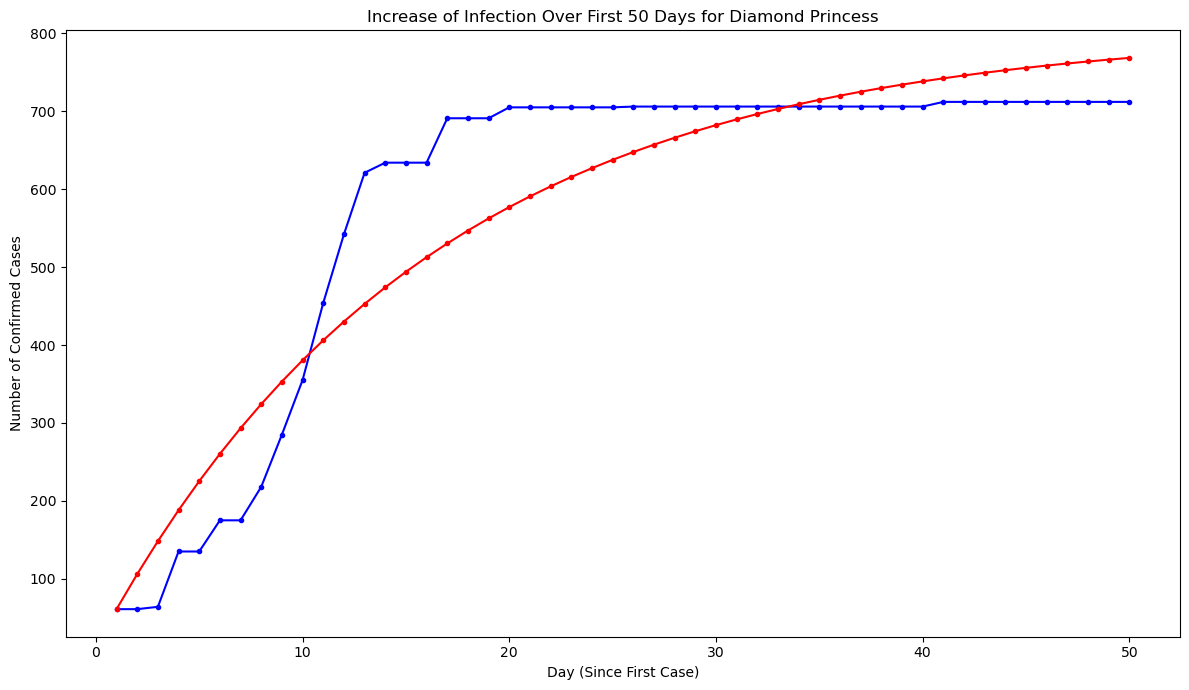

In [13]:
x=diamond_princess_first_50_days['Day']
y=diamond_princess_first_50_days['CONFIRMED']
Plotting_covid(x,y,approximation=True,u_approximation=u_approximation)

In [14]:
#create day column
n=200
diamond_princess_data['Day'] = range(1, len(diamond_princess_data) + 1)
# Filter the Diamond Princess data for the first 50 days
diamond_princess_first_50_days = diamond_princess_data[diamond_princess_data['Day'] <= n]

U_comp=diamond_princess_first_50_days[['CONFIRMED', 'DEATHS', 'RECOVERED']].to_numpy()
U_comp=U_comp.reshape(n,3)
T=diamond_princess_first_50_days['Day'].to_numpy()
T=T.reshape(n,1)
T_traj=diamond_princess_data['Day'].to_numpy()
T_traj=T_traj.reshape(262,1)
u0_comp=[61,0,0]
testings2=SINDY(U=U_comp,T_traj=T_traj,fit_time=True,T=T,u0=u0_comp,derivation="finite",POLYNOMIAL_ORDER = 1,USE_TRIG = False,THRESHOLD = 0.0001,MAX_ITERATIONS = 10)
u_comp_approximation=testings2.compute_trajectory()

C:\Users\fisay\AppData\Local\Temp\ipykernel_21220\362283398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diamond_princess_data['Day'] = range(1, len(diamond_princess_data) + 1)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.955e+03, tolerance: 1.655e+03
  model = cd_fast.enet_coordinate_descent(


0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.367e+00, tolerance: 2.670e-01
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.575e+04, tolerance: 7.175e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\fisay\AppData\Roaming\Python\Python39\site-packages\derivative\differentiation.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

In [27]:
U_comp=diamond_princess_data[diamond_princess_data['Day'] >= 0][['CONFIRMED', 'DEATHS', 'RECOVERED']].to_numpy()

In [28]:
U_comp

array([[ 61,   0,   0],
       [ 61,   0,   0],
       [ 64,   0,   0],
       [135,   0,   0],
       [135,   0,   0],
       [175,   0,   0],
       [175,   0,   0],
       [218,   0,   0],
       [285,   0,   0],
       [355,   0,   0],
       [454,   0,   0],
       [542,   0,   0],
       [621,   0,   1],
       [634,   2,   1],
       [634,   2,   1],
       [634,   2,   1],
       [691,   3,   0],
       [691,   3,   0],
       [691,   3,   0],
       [705,   4,  10],
       [705,   4,  10],
       [705,   6,  10],
       [705,   6,  10],
       [705,   6,  10],
       [705,   6,  10],
       [706,   6,  10],
       [706,   6,  10],
       [706,   6,  10],
       [706,   6,  40],
       [706,   6,  40],
       [706,   6,  40],
       [706,   6,  40],
       [706,   6,  40],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [706,   7, 325],
       [712,   7, 325],
       [712,   7

In [16]:
u_comp_approximation[200:]

array([[716.17359422,  13.14488713, 701.73014761],
       [716.37291456,  13.1521186 , 702.56880141],
       [716.57976364,  13.15924333, 703.39674967],
       [716.79338903,  13.16627197, 704.21450047],
       [717.01291589,  13.17321503, 705.02257702],
       [717.23734696,  13.18008293, 705.82151766],
       [717.4655626 ,  13.18688597, 706.61187583],
       [717.69632071,  13.19363431, 707.39422011],
       [717.92825684,  13.20033805, 708.16913419],
       [718.15988408,  13.20700713, 708.93721689],
       [718.38959315,  13.21365139, 709.69908215],
       [718.61565233,  13.22028056, 710.45535903],
       [718.8362075 ,  13.22690426, 711.2066917 ],
       [719.05073018,  13.23351672, 711.95303931],
       [719.26727499,  13.24002939, 712.69045017],
       [719.48719209,  13.24643829, 713.418641  ],
       [719.71020209,  13.25275703, 714.13812936],
       [719.93603046,  13.2589985 , 714.84940867],
       [720.16440741,  13.26517485, 715.55294823],
       [720.39506801,  13.27129

[[ 3.63380134e+01 -1.38828225e-01 -5.42582747e+00]
 [-1.06098850e-02  8.71055867e-04  2.71498853e-02]
 [-4.80815666e+00 -3.63397889e-02 -7.20804448e-02]
 [ 4.93489724e-02  0.00000000e+00 -1.74156985e-02]]


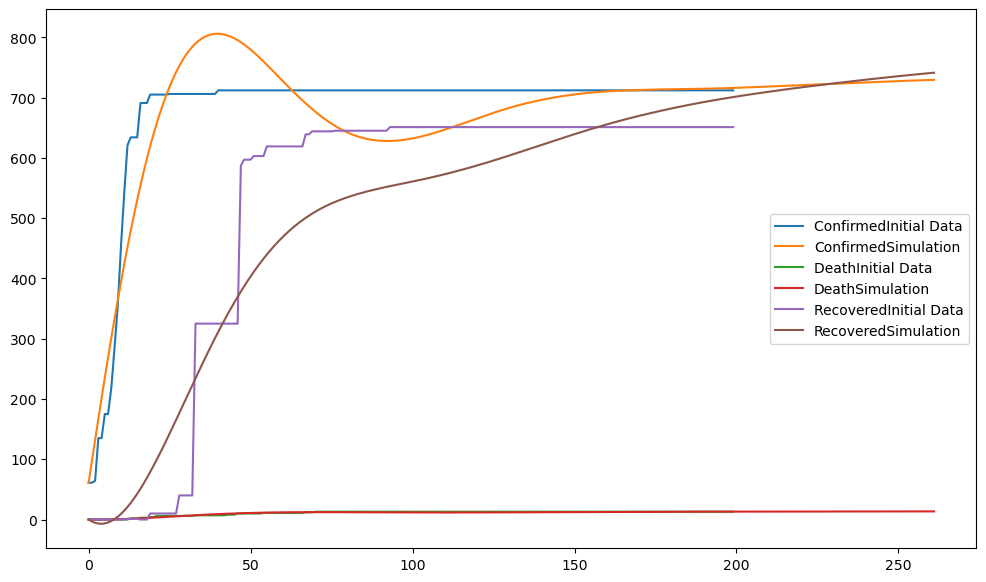

In [175]:
print(testings2.xi)
plot_org_sim(org=U_comp,sim=u_comp_approximation,legend=['Confirmed','Death','Recovered'])

In [ ]:
d=diamond_princess_data[['CONFIRMED', 'DEATHS', 'RECOVERED']].to_numpy()[200:,:]
x=u_comp_approximation[200:,:]


In [191]:
CalcAccuracy(d, x)

0.9945061727602895

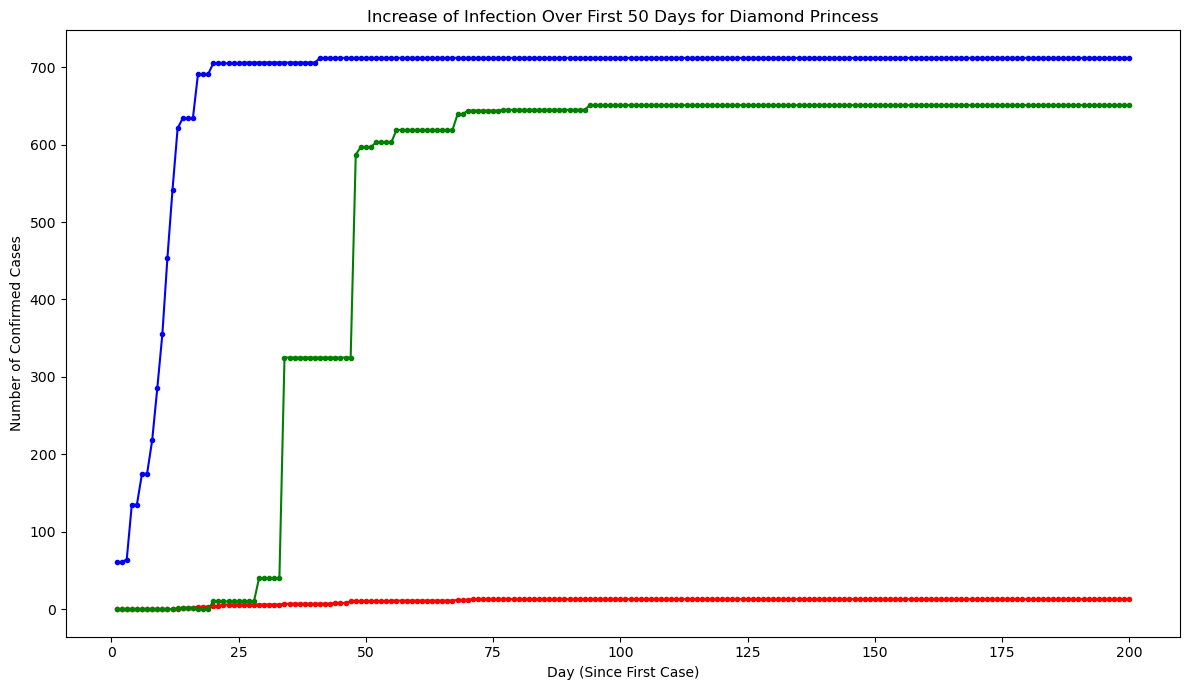

In [165]:
plt.figure(figsize=(12, 7))
plt.plot(diamond_princess_first_50_days['Day'],diamond_princess_first_50_days['CONFIRMED'], marker='.', color='blue')
plt.plot(diamond_princess_first_50_days['Day'],diamond_princess_first_50_days['DEATHS'],  marker='.', color='red')
plt.plot(diamond_princess_first_50_days['Day'],diamond_princess_first_50_days['RECOVERED'],  marker='.', color='green')
plt.title('Increase of Infection Over First 50 Days for Diamond Princess')
plt.xlabel('Day (Since First Case)')
plt.ylabel('Number of Confirmed Cases')
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [20]:
u_comp_approximation

array([[ 6.10000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 6.82907179e+01,  2.00000000e-01,  1.20270344e+00],
       [ 4.27544833e+01,  4.00000000e-01,  1.50264952e+00],
       [-2.09183874e+01,  6.00000000e-01,  9.82686615e-01],
       [-1.39203323e+02,  8.00000000e-01, -2.74336882e-01],
       [-3.41375484e+02,  1.00000000e+00, -2.18557258e+00],
       [-6.78208436e+02,  1.20000000e+00, -4.66817211e+00],
       [-1.22156905e+03,  1.40000000e+00, -7.63928706e+00],
       [-2.10444407e+03,  1.60000000e+00, -1.10160691e+01],
       [-3.64685407e+03,  1.80000000e+00, -1.47156697e+01],
       [-6.38869075e+03,  2.00000000e+00, -1.86552406e+01],
       [-1.13144846e+04,  2.20000000e+00, -2.27519334e+01],
       [-2.04327877e+04,  2.40000000e+00, -2.69228997e+01],
       [-3.85162673e+04,  2.60000000e+00, -3.10852911e+01],
       [-7.49392992e+04,  2.80000000e+00, -3.51562592e+01],
       [-1.50145708e+05,  3.00000000e+00, -3.90529557e+01],
       [-3.16508709e+05,  3.20000000e+00

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
scaler3 = MinMaxScaler()
scaler4 = StandardScaler()

In [81]:
U_nrm = scaler1.fit_transform(U_comp)
U_std = scaler2.fit_transform(U_comp)
T_norm=scaler3.fit_transform(T)
T_std=scaler4.fit_transform(T)

In [69]:

testings3=SINDY(U=U_nrm,T=T_norm,u0=U_nrm[0],derivation="total",POLYNOMIAL_ORDER = 2,USE_TRIG = False,THRESHOLD = 0.025,MAX_ITERATIONS = 10)
u_comp_nrm=testings3.compute_trajectory()

0


C:\Users\fisay\AppData\Roaming\Python\Python39\site-packages\derivative\differentiation.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dX = np.array([list(self.compute_for(t, x, np.arange(len(t)))) for x in X])


In [70]:
testings3.xi

array([[  2.49024272,   2.39705397,   2.40114496],
       [ -5.97985709,  -6.69953099,  -6.75635125],
       [ -8.66788889,  -6.07940011,  -8.68996124],
       [-37.15395278, -94.97580011, -90.28915998],
       [  4.16959201,   5.31880162,   5.40042883],
       [ 10.30225637,   6.06949085,   9.320269  ],
       [ 33.3855566 ,  93.77091487,  88.01687993],
       [ -1.66844907,   0.17297885,  -0.95586037],
       [  5.57755725,   1.22577863,   3.53563505],
       [ -1.4284359 ,  -0.17109615,  -0.95357739]])

In [97]:
U_comp_un_nrm=scaler1.inverse_transform(u_comp_nrm)
CalcAccuracy(U_comp,U_comp_un_nrm)

0.6749724409594013

In [123]:

testings4=SINDY(U=U_std,T=T_std,u0=U_std[0],derivation="total",POLYNOMIAL_ORDER = 2,USE_TRIG = False,THRESHOLD = 0.025,MAX_ITERATIONS = 10)
u_comp_std=testings4.compute_trajectory()

0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.601e-03, tolerance: 3.554e-03
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.660e-04, tolerance: 4.493e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\fisay\AppData\Roaming\Python\Python39\site-packages\derivative\differentiation.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

In [124]:
testings4.xi

array([[ -5.35542076,  -7.90757393,  -9.67845773],
       [  9.54698069,  13.9436059 ,  17.22920365],
       [  0.98248533,   0.        ,  -0.10311471],
       [ -8.2312734 , -10.1790843 , -12.57512396],
       [  0.59476158,   0.69758156,   0.78079185],
       [ -0.32343319,   0.92985488,   0.65022071],
       [ 13.49810525,  16.72444389,  21.35752868],
       [  0.31487679,   0.12793196,   0.29935385],
       [ -0.18728087,  -0.06405571,  -0.50006195],
       [  0.10070906,   0.30133283,   0.42029523]])

In [121]:
U_comp_un_std=scaler2.inverse_transform(u_comp_std)

In [122]:
CalcAccuracy(U_comp,U_comp_un_std)

0.7413594955301286